In [ ]:
# Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, Input, GlobalAveragePooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import librosa
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K


In [17]:
# Step 2: Load Dataset
df = pd.read_csv('DATASET-balanced.csv')
print("Dataset shape:", df.shape)
df.head()



Dataset shape: (11778, 27)


,chroma_stft,rms,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,LABEL
0,0.338055,0.027948,2842.948867,4322.916759,6570.586186,0.041050,-462.169586,90.311272,19.073769,24.046888,...,-6.686564,0.902086,-7.251551,-1.198342,4.747403,-4.986279,0.953935,-5.013138,-6.779060,FAKE
1,0.443766,0.037838,2336.129597,3445.777044,3764.949874,0.047730,-409.413422,120.348808,-7.161531,5.114784,...,-2.131157,-6.876417,-1.359395,0.326401,-5.420016,-2.109968,-1.757634,-9.537907,-8.494421,FAKE
2,0.302528,0.056578,2692.988386,2861.133180,4716.610271,0.080342,-318.996033,120.490273,-24.625771,23.891073,...,-5.853725,-3.724773,-6.627182,-5.117002,-6.072106,-0.994653,-1.617120,-3.922354,-7.033001,FAKE
3,0.319933,0.031504,2241.665382,3503.766175,3798.641521,0.047180,-404.636749,136.320908,2.308172,-3.907071,...,-1.898315,-2.046493,-7.176277,-3.293508,4.209121,0.121835,-5.407063,-3.654926,-3.274857,FAKE
4,0.420055,0.016158,2526.069123,3102.659519,5025.077899,0.051905,-410.497925,152.731400,-18.266771,51.993462,...,-1.952340,0.810868,6.238493,6.555839,7.535542,2.849219,2.616843,-1.793357,-5.060998,FAKE


In [18]:
# Step 3: Preprocess Dataset
X = df.drop(['LABEL'], axis=1).values
y = df['LABEL'].apply(lambda x: 0 if x == 'FAKE' else 1).values  # Convert LABEL to binary
X = X / np.max(np.abs(X), axis=1, keepdims=True)
X = X.reshape(X.shape[0], X.shape[1], 1)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



In [19]:
# Step 4: Build CNN + LSTM Model
model = Sequential([
    Conv1D(filters=128, kernel_size=3, activation='relu', padding='same', input_shape=(X.shape[1], 1)),
    Dropout(0.3),
    Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Adjust the loss function to penalize false negatives more heavily
def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_0 = 1.0  # Weight for "Original"
    weight_for_1 = 2.0  # Weight for "Cloned"
    
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * weight_for_1 + (1. - y_true) * weight_for_0
    
    return weight_vector * bce

model.compile(optimizer='adam', loss=weighted_binary_crossentropy, metrics=['accuracy'])
model.summary()


C:\Users\ayush\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 26, 128)        │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 26, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 26, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 362,241 (1.38 MB)

 Trainable params: 362,241 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Step 5: Train Model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.5002 - loss: 0.9749 - val_accuracy: 0.5013 - val_loss: 0.8455
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 27s 99ms/step - accuracy: 0.5002 - loss: 0.9749 - val_accuracy: 0.5013 - val_loss: 0.8455
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5123 - loss: 0.8514 - val_accuracy: 0.5008 - val_loss: 0.7952
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.5123 - loss: 0.8514 - val_accuracy: 0.5008 - val_loss: 0.7952
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.6398 - loss: 0.8170 - val_accuracy: 0.6902 - val_loss: 0.7621
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.6398 - loss: 0.8170 - val_accuracy: 0.6902 - val_loss: 0.7621
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6847 - loss: 0.7880 - val_accuracy: 0.7401 - val_loss: 0.7637
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6847 - loss: 0.788

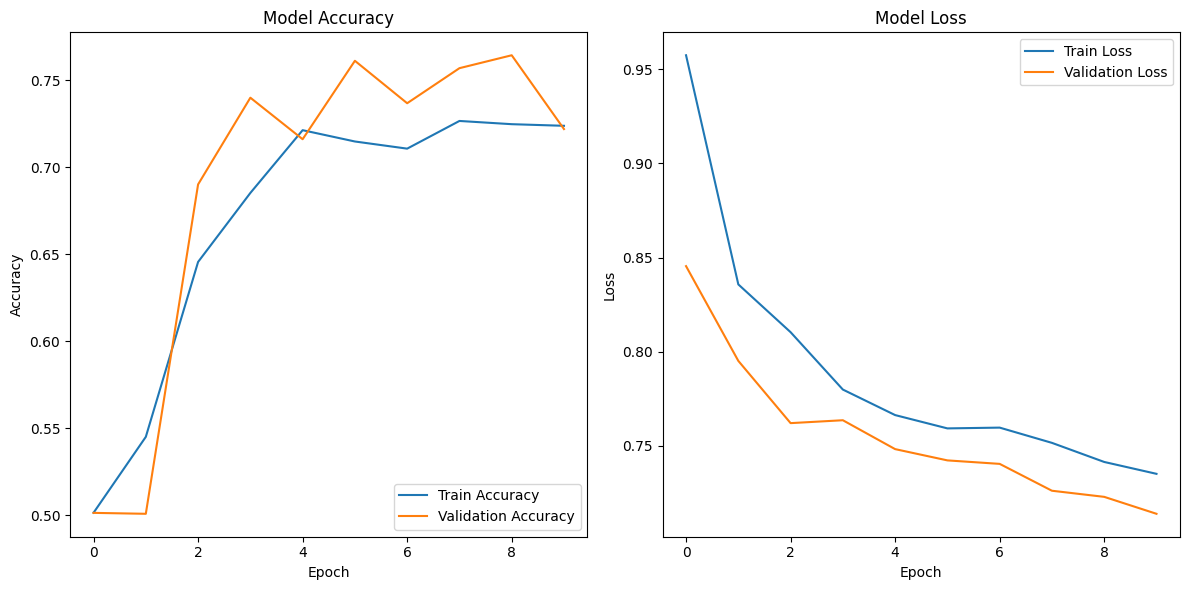

In [21]:
# Step 6: Visualize Training History
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [33]:
# Step 10: Save the Trained Model
model.save('trained_model.h5')
print('Model saved as trained_model.h5')


Model saved as trained_model.h5


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7367 - loss: 0.7075
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.7367 - loss: 0.7075
Test Accuracy: 73.13%
 1/74 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/stepTest Accuracy: 73.13%
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step


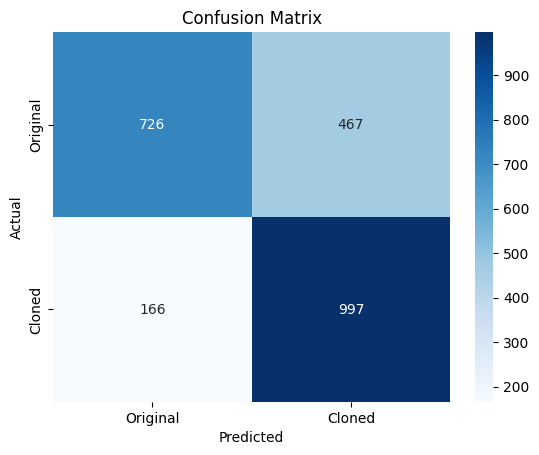

              precision    recall  f1-score   support

    Original       0.81      0.61      0.70      1193
      Cloned       0.68      0.86      0.76      1163

    accuracy                           0.73      2356
   macro avg       0.75      0.73      0.73      2356
weighted avg       0.75      0.73      0.73      2356



In [34]:
# Step 6: Evaluate Model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Generate predictions
y_pred = (model.predict(X_test) > 0.5).astype('int32')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Cloned'], yticklabels=['Original', 'Cloned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_test, y_pred, target_names=['Original', 'Cloned']))


In [35]:
# Analyze Confusion Matrix
# Calculate False Positive Rate and False Negative Rate
FP = cm[0][1]  # False Positives
FN = cm[1][0]  # False Negatives
TP = cm[1][1]  # True Positives
TN = cm[0][0]  # True Negatives
FPR = FP / (FP + TN)  # False Positive Rate
FNR = FN / (FN + TP)  # False Negative Rate
print(f'False Positive Rate: {FPR:.2f}')
print(f'False Negative Rate: {FNR:.2f}')

False Positive Rate: 0.39
False Negative Rate: 0.14


Dataset Balance:
LABEL
FAKE    5889
REAL    5889
Name: count, dtype: int64


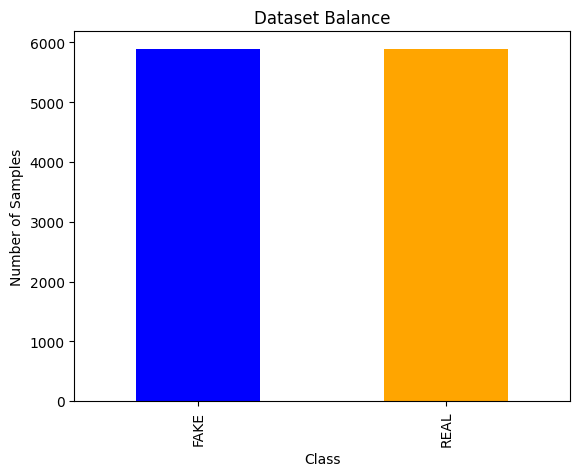

In [36]:
# Check Dataset Balance
# Count the number of samples in each class
class_counts = df['LABEL'].value_counts()
print('Dataset Balance:')
print(class_counts)
# Visualize dataset balance
class_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title('Dataset Balance')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


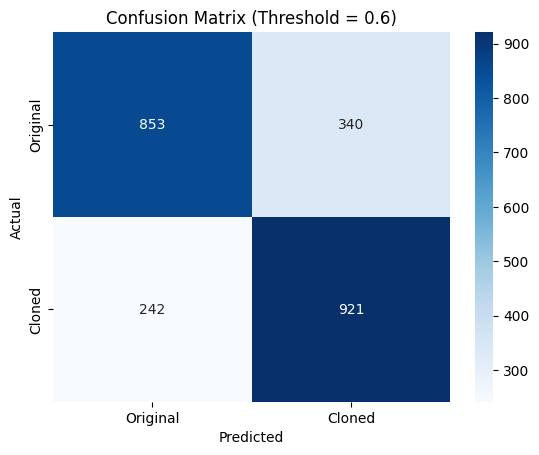

              precision    recall  f1-score   support

    Original       0.78      0.72      0.75      1193
      Cloned       0.73      0.79      0.76      1163

    accuracy                           0.75      2356
   macro avg       0.75      0.75      0.75      2356
weighted avg       0.75      0.75      0.75      2356



In [26]:
# Experiment with Threshold Adjustment
# Adjust the threshold for binary classification
threshold = 0.6  # Example threshold
y_pred_adjusted = (model.predict(X_test) > threshold).astype('int32')
# Confusion Matrix with adjusted threshold
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Original', 'Cloned'], yticklabels=['Original', 'Cloned'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Threshold = {threshold})')
plt.show()
# Classification Report with adjusted threshold
print(classification_report(y_test, y_pred_adjusted, target_names=['Original', 'Cloned']))

In [27]:
# Step 7: Define WaveNet-Inspired Feature Extraction for Audio
def extract_wavenet_features(audio_path, sr=16000):
    y, _ = librosa.load(audio_path, sr=sr)
    y = librosa.util.fix_length(y, size=sr)
    y = y.reshape(1, -1, 1)
    conv_model = Sequential([
        Input(shape=(sr, 1)),
        Conv1D(32, kernel_size=2, dilation_rate=1, activation='relu', padding='causal'),
        Conv1D(64, kernel_size=2, dilation_rate=2, activation='relu', padding='causal'),
        Conv1D(128, kernel_size=2, dilation_rate=4, activation='relu', padding='causal'),
        GlobalAveragePooling1D()
    ])
    features = conv_model.predict(y)
    return features


In [30]:
import librosa as lb
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def extract_features(path):
    # Load the audio file
    y, sr = lb.load(path)
    features = []
    
    # Extract various features
    chroma_stft = np.mean(lb.feature.chroma_stft(y=y, sr=sr))
    spct_cent   = np.mean(lb.feature.spectral_centroid(y=y, sr=sr))
    spect_band  = np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr))
    rollof      = np.mean(lb.feature.spectral_rolloff(y=y, sr=sr))
    rms         = np.mean(lb.feature.rms(y=y))
    zero_crossing_rate = np.mean(lb.feature.zero_crossing_rate(y=y))
    
    # Append features to list
    features.append(chroma_stft)
    features.append(rms)
    features.append(spct_cent)
    features.append(spect_band)
    features.append(rollof)
    features.append(zero_crossing_rate)
    
    # Extract MFCCs and modify them (removing coefficients at indices 3 and 17)
    mfccs = lb.feature.mfcc(y=y, sr=sr)
    mfccs = np.delete(mfccs, 3, axis=0)
    mfccs = np.delete(mfccs, 17, axis=0)
    
    # Compute the Short-Time Fourier Transform (STFT) and convert to dB
    D = lb.stft(y)
    S_db = lb.amplitude_to_db(np.abs(D), ref=np.max)
    
    # Plot the spectrogram
    plt.figure(figsize=(12, 8))
    lb.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()
    
    # Append the mean of each MFCC coefficient to the features list
    for mean in np.mean(mfccs, axis=1):
        features.append(mean)
    
    return features

# Example usage:

In [37]:
# Step 11: Load the Trained Model
# Define the custom loss function again for loading the model
def weighted_binary_crossentropy(y_true, y_pred):
    weight_for_0 = 1.0  # Weight for "Original"
    weight_for_1 = 2.0  # Weight for "Cloned"
    
    bce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * weight_for_1 + (1. - y_true) * weight_for_0
    
    return weight_vector * bce

# Load the model with the custom loss function
loaded_model = load_model('trained_model.h5', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})
print('Model loaded successfully')


Model loaded successfully


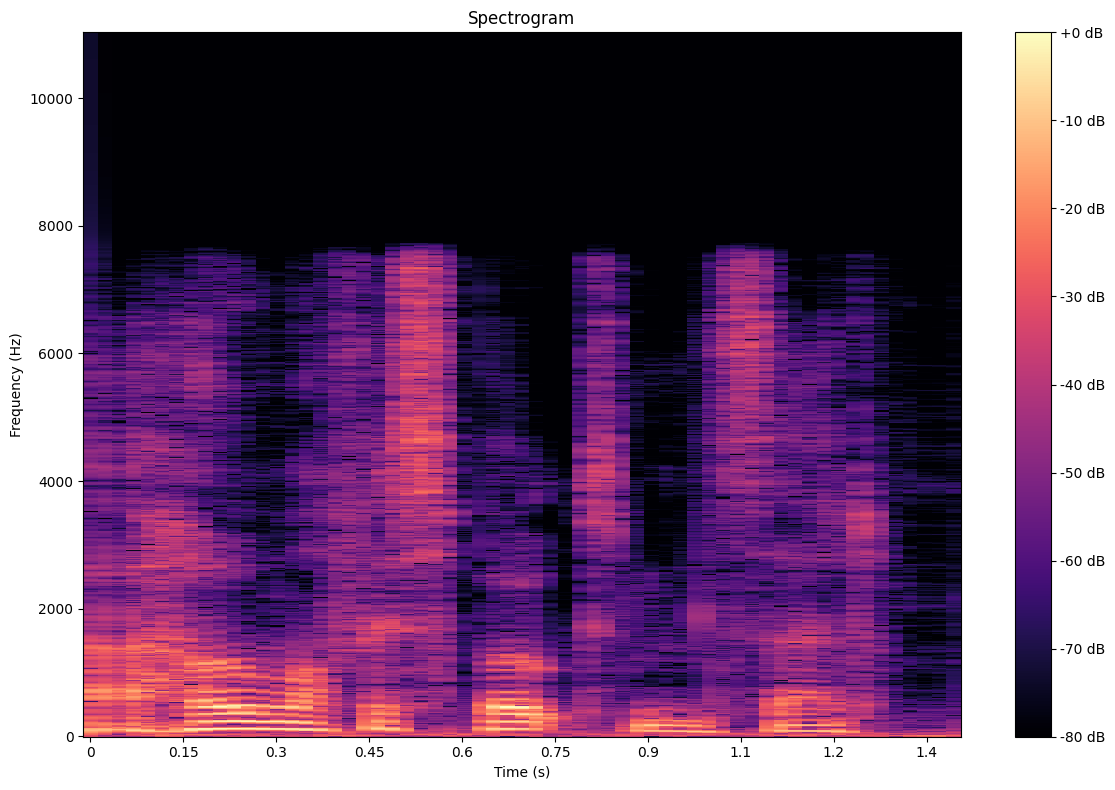

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Prediction: Cloned (88.20% confidence)
Audio File: Testing_set\Original\3speaker2ground_truth.wav
Predicted Label: Cloned with 88.20% confidence
Prediction: Cloned (88.20% confidence)
Audio File: Testing_set\Original\3speaker2ground_truth.wav
Predicted Label: Cloned with 88.20% confidence


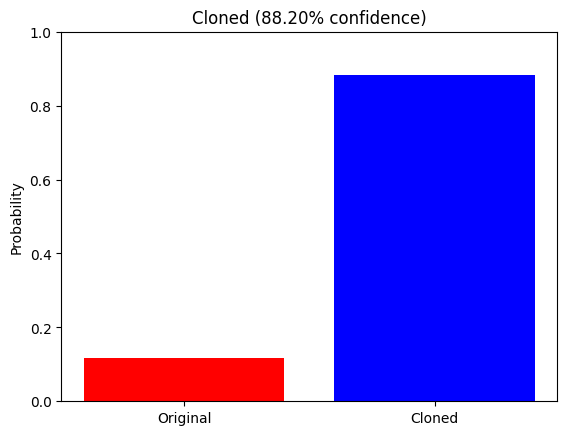

In [38]:
# Step 12: Use the Loaded Model for Prediction
def predict_with_loaded_model(audio_path):
    features = extract_features(audio_path)
    features = np.array(features).reshape(1, -1)  # Ensure features have the correct shape
    prediction = loaded_model.predict(features)
    prediction = prediction[0][0]
    confidence = prediction if prediction > 0.5 else 1 - prediction
    label = 'Original' if prediction >= 0.5 else 'Cloned'
    print(f'Prediction: {label} ({confidence*100:.2f}% confidence)')
    return prediction, label, confidence

# Generate predictions and visualize
audio_path = r'Testing_set\Original\3speaker2ground_truth.wav'  # Example audio file
prediction, label, confidence = predict_with_loaded_model(audio_path)
print(f'Audio File: {audio_path}')
print(f'Predicted Label: {label} with {confidence*100:.2f}% confidence')

# Visualize prediction
plt.bar(['Original', 'Cloned'], [prediction, 1-prediction], color=['red', 'blue'])
plt.title(f'{label} ({confidence*100:.2f}% confidence)')
plt.ylabel('Probability')
plt.ylim(0, 1)  # Ensures the bars properly reflect probabilities

plt.show()

✅ Model loaded successfully


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
🎧 Prediction: Cloned (53.33% confidence)
🎧 Prediction: Cloned (53.33% confidence)


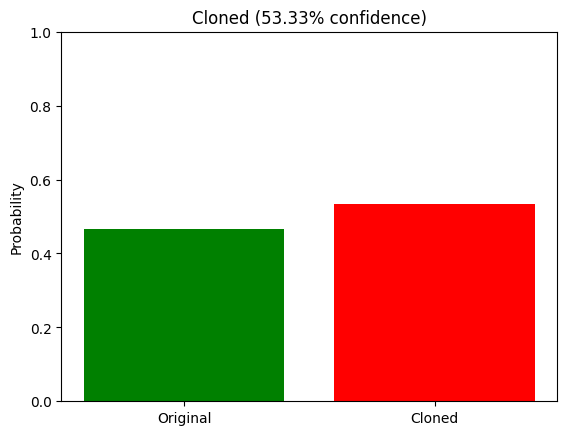

('Cloned', 0.5332991778850555)

In [42]:
import numpy as np
import librosa as lb
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('trained_model.h5', custom_objects={'weighted_binary_crossentropy': weighted_binary_crossentropy})
print("✅ Model loaded successfully")

# Feature extraction function matching training data
def extract_features(audio_path):
    y, sr = lb.load(audio_path)
    features = []

    # Basic spectral and energy features
    features.append(np.mean(lb.feature.chroma_stft(y=y, sr=sr)))
    features.append(np.mean(lb.feature.rms(y=y)))
    features.append(np.mean(lb.feature.spectral_centroid(y=y, sr=sr)))
    features.append(np.mean(lb.feature.spectral_bandwidth(y=y, sr=sr)))
    features.append(np.mean(lb.feature.spectral_rolloff(y=y, sr=sr)))
    features.append(np.mean(lb.feature.zero_crossing_rate(y=y)))

    # MFCCs (remove indices 3 and 17 to match training)
    mfccs = lb.feature.mfcc(y=y, sr=sr)
    mfccs = np.delete(mfccs, [3, 17], axis=0)
    features.extend(np.mean(mfccs, axis=1))

    return np.array(features)

# Prediction function
def predict_audio(audio_path):
    features = extract_features(audio_path)
    features = features.reshape(1, -1)  # Shape: (1, 27)
    
    # Normalize like in training
    features = features / np.max(np.abs(features), axis=1, keepdims=True)
    features = features.reshape(features.shape[0], features.shape[1], 1)  

    prediction = model.predict(features)[0][0]

    label = "Original" if prediction >= 0.6 else "Cloned"
    confidence = prediction if prediction >= 0.6 else 1 - prediction

    print(f"🎧 Prediction: {label} ({confidence * 100:.2f}% confidence)")

    # Visualization
    plt.bar(['Original', 'Cloned'], [prediction, 1 - prediction], color=['green', 'red'])
    plt.title(f'{label} ({confidence * 100:.2f}% confidence)')
    plt.ylim(0, 1)
    plt.ylabel('Probability')
    plt.show()

    return label, confidence

# Example usage
audio_path = 'Testing_set/Original/3speaker2ground_truth.wav'
predict_audio(audio_path)
